In [14]:
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from jupyterthemes import jtplot
jtplot.style()

def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

# Unsupervised Learning
Yann LeCun famously said that “if intelligence was a cake, unsupervised learning would be the cake, supervised learning would be the icing on the cake, and reinforcement learning would be the cherry on the cake.”

In this chapter we will explore 3 types of unsupervised learnining:
- Clustering: a great tool for data analysis, customer segmentation, recommender systems, search engines, image segmentation, semi-supervised learning, dimensionality reduction, and more.
- Anomaly Detection: The objective is to learn what “normal” data looks like, and then use that to detect abnormal instances, such as defective items on a production line or a new trend in a time series.
- Density Estimation: This is the task of estimating the probability density function (PDF) of the random process that generated the dataset. Density estimation is commonly used for anomaly detection: instances located in very low-density regions are likely to be anomalies. It is also useful for data analysis and visualization.

## Clustering
Clustering is the task of identifying similar instances into *clusters*, or groups of similar instances.

It's applications are wide, here are some examples:
- Customer Segmentation: You can cluster your customers based on their purchases and their activity on your website. This is useful to understand who your customers are and what they need, so you can adapt your products and marketing campaigns to each segment. For example, customer segmentation can be useful in recommender systems to suggest content that other users in the same cluster enjoyed.
- Data Analysis: When you analyze a new dataset, it can be helpful to run a clustering algorithm, and then analyze each cluster separately.
- As a dimensionality reduction algorithm: Once a dataset has been clustered, it is usually possible to measure each instance’s affinity with each cluster (affinity is any measure of how well an instance fits into a cluster). Each instance’s feature vector x can then be replaced with the vector of its cluster affinities. If there are k clusters, then this vector is k-dimensional. This vector is typically much lower-dimensional than the original feature vector, but it can preserve enough information for further processing.
- Anomaly detection: Any instance that has a low affinity to all the clusters is likely to be an anomaly. For example, if you have clustered the users of your website based on their behavior, you can detect users with unusual behavior, such as an unusual number of requests per second. Anomaly detection is particularly useful in detecting defects in manufacturing, or for fraud detection.
- Semi-supervised learning: If you only have a few labels, you could perform clustering and propagate the labels to all the instances in the same cluster.
- Search Engines: Some search engines let you search for images that are similar to a reference image. To build such a system, you would first apply a clustering algorithm to all the images in your database; similar images would end up in the same cluster. Then when a user provides a reference image, all you need to do is use the trained clustering model to find this image’s cluster, and you can then simply return all the images from this cluster.
- Image Segmentation: By clustering pixels according to their color, then replacing each pixel’s color with the mean color of its cluster, it is possible to considerably reduce the number of different colors in the image. Image segmentation is used in many object detection and tracking systems, as it makes it easier to detect the contour of each object.

### K-Means
Consider the following unlabeled dataset, it clearly has 5 blobs of instances. We'll train and fit KMeans on this data

In [2]:
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

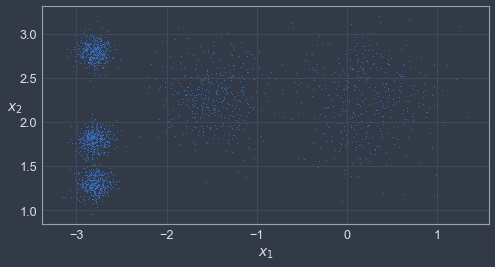

In [3]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.show()

In [4]:
from sklearn.cluster import KMeans

k = 5
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)
y_pred

array([4, 1, 0, ..., 3, 0, 1])

With the cluster labels, we can assign new instances to the cluster whose centroid is closest

In [5]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([0, 0, 3, 3])

And we can plot the decision boundaries as a *Voronoi Tesselation* diagram

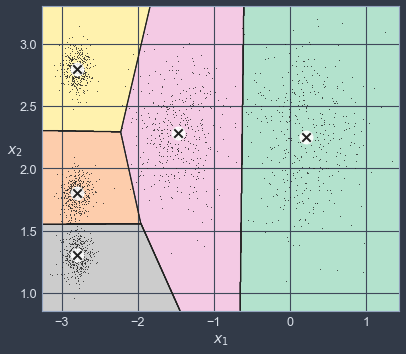

In [6]:
plot_decision_boundaries(kmeans, X)

Most instances are well labelled, but the ones near the decision boundaries were probably mislabelled. One of the disadvantages of K-means is that it does not behave very well when the blobs have very different diameters because it only cares about distance to the centroid when assigning labels

Instead of doing *hard clustering* (i.e. assigning each instance to a single cluster), we can give each instance a score per cluster (*soft clustering*). The score can be distance between the instance and the centroid, a similarity score (or affinity) such as the Gaussian RBF.

In KMeans, we can use `transform()` to measure distance from each instance to every centroid

In [7]:
kmeans.transform(X_new)

array([[0.33143587, 2.81025683, 1.4904329 , 2.9042344 , 2.88642367],
       [2.79863242, 5.80668475, 4.47173193, 5.84739223, 5.84270116],
       [3.29838701, 1.21308547, 1.69469383, 0.29040966, 1.70884549],
       [3.2223216 , 0.72424977, 1.55215675, 0.36159148, 1.21364722]])

### The Algorithm

It is a fairly straightforward algorithm:
1. Start by randomly placing *k* centroids
2. Label the instances that are closest to the centroids
3. Update the centroid locations to the mean of the instances in the cluster
4. Repeat 2 and 3 until convergence

Convergence is always guaranteed, albie it may not converge to the right solution, it depends on the centroid initialization.

By default, SKlearn runs K-Means multiple times and keeps the best solution. How does it know what is the best solution? It uses the *inertia* of the model, which is the mean squared distance between each instance and its closest centroid.

### Finding the optimal number of clusters

You may think that choosing *k* with lowest inertia yields the best model right? Unfortunatly inertia is not a good performance metric as it will always go down as k increases.

One heuristic method commonly used is the *elbow method*, which plots the inertias for various values of *k* and looks for the point where the decrease in inertia changes sharply (forming an elbow)

In [8]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

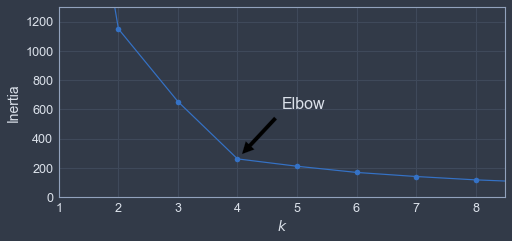

In [10]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
plt.show()

This method suggests 4 clusters for the dataset above

Another method, is to use the *silhouette score*, which is the mean silhouette coefficient over all instances. The silhouette coeffiecient is defined as 
$$ \frac{b-a}{\max(a, b)}$$
Where *a* is the mean distance to other instances in the same cluster (i.e. mean intra-cluster distance) and *b* is the mean nearest cluster distance (i.e. mean distance to the instances of the next closest cluster, excluding the instance's own cluster). It  ranges between -1 and +1, with +1 meaning the instance is well inside its own cluster and far from other clusters, close to 0 means it is close to a cluster boundary and a coefficient of -1 means the instance may have been assigned to the wrong cluster.

In [11]:
from sklearn.metrics import silhouette_score
silhouette_score(X, kmeans.labels_)

0.6555176425728279

Let's have a look at the silhouette scores for the values of *k* plotted above

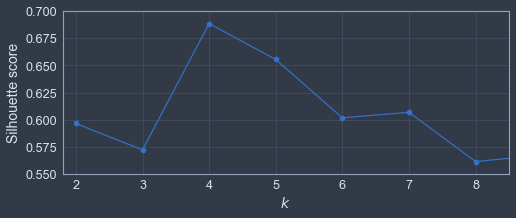

In [12]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()

As you can see, this visualization is much richer than the previous one: in particular, although it confirms that $k=4$ is a very good choice, but it also underlines the fact that $k=5$ is quite good as well.

An even more informative visualization is given when you plot every instance's silhouette coefficient, sorted by the cluster they are assigned to and by the value of the coefficient. This is called a silhouette diagram:

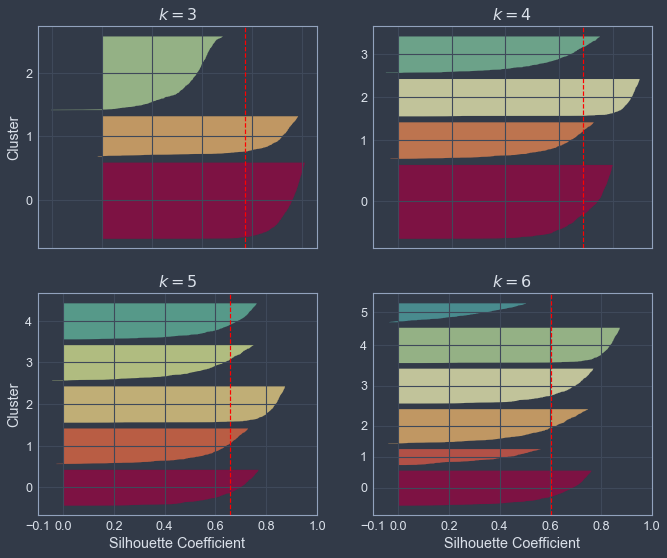

In [15]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

Each diagram contains one knife shape per cluster. The shape’s height indicates the number of instances the cluster contains, and its width represents the sorted silhouette coefficients of the instances in the cluster (wider is better). The dashed line indicates the mean silhouette coefficient.

The vertical dashed lines represent the silhouette score for each number of clusters. When most of the instances in a cluster have a lower coefficient than this score (i.e., if many of the instances stop short of the dashed line, ending to the left of it), then the cluster is rather bad since this means its instances are much too close to other clusters. We can see that when k = 3 and when k = 6, we get bad clusters. But when k = 4 or k = 5, the clusters look pretty good: most instances extend beyond the dashed line, to the right and closer to 1.0. When k = 4, the cluster at index 1 (the third from the top) is rather big. When k = 5, all clusters have similar sizes. So, even though the overall silhouette score from k = 4 is slightly greater than for k = 5, it seems like a good idea to use k = 5 to get clusters of similar sizes.

### Limits of K-means

One of the drawbacks of Kmeans is that when the clusters have varying sizes, differing densities or non-spherical shapes, it doesn't work very well. Take the example below for instance

In [16]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

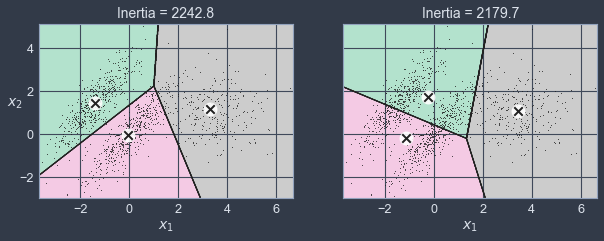

In [17]:
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)

plt.show()

So, depending on the data, different clustering algorithms may perform better. On these types of elliptical clusters, Gaussian mixture models work great.

## Using clustering for Image Segmentation